In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torch\cuda\__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [ ]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 리사이징
    transforms.ToTensor()
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

In [ ]:
# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

In [ ]:
# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

In [ ]:
# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

In [ ]:
# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

In [13]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [14]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: C:\Users\user\Downloads\animals10\raw-img
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [15]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 20943
    Root location: C:\Users\user\Downloads\animals10\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5177, 0.5003, 0.4126), std=(0.2135, 0.213, 0.2151))
           )

In [16]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 5236
    Root location: C:\Users\user\Downloads\animals10\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5177, 0.5003, 0.4126), std=(0.2135, 0.213, 0.2151))
           )

In [ ]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

In [17]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    #평균 훈련 손실 계산
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [18]:
# 모델 훈련
import time
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    elapsed_time = time.time() - start_time
    test(model, test_loader)
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")


Train Loss: 2.0614, Accuracy: 26.61%
Epoch 1 completed in 126.12 seconds
Test Loss: 1.9306, Accuracy: 31.57%
Train Loss: 1.8029, Accuracy: 36.59%
Epoch 2 completed in 219.23 seconds
Test Loss: 1.7295, Accuracy: 38.52%
Train Loss: 1.6484, Accuracy: 43.06%
Epoch 3 completed in 299.57 seconds
Test Loss: 1.6704, Accuracy: 39.25%
Train Loss: 1.4930, Accuracy: 48.54%
Epoch 4 completed in 414.96 seconds
Test Loss: 1.5053, Accuracy: 47.88%
Train Loss: 1.3502, Accuracy: 53.53%
Epoch 5 completed in 493.37 seconds
Test Loss: 1.3577, Accuracy: 52.10%
Train Loss: 1.2248, Accuracy: 57.94%
Epoch 6 completed in 571.80 seconds
Test Loss: 1.4889, Accuracy: 51.11%
Train Loss: 1.1075, Accuracy: 62.20%
Epoch 7 completed in 650.71 seconds
Test Loss: 1.3699, Accuracy: 52.43%
Train Loss: 0.9970, Accuracy: 65.88%
Epoch 8 completed in 729.20 seconds
Test Loss: 1.3240, Accuracy: 56.42%
Train Loss: 0.8898, Accuracy: 69.48%
Epoch 9 completed in 807.08 seconds
Test Loss: 1.3190, Accuracy: 56.86%
Train Loss: 0.7758,

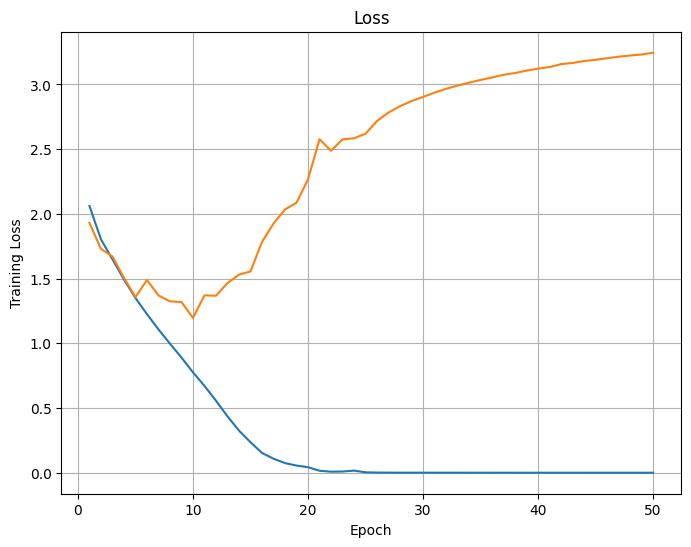

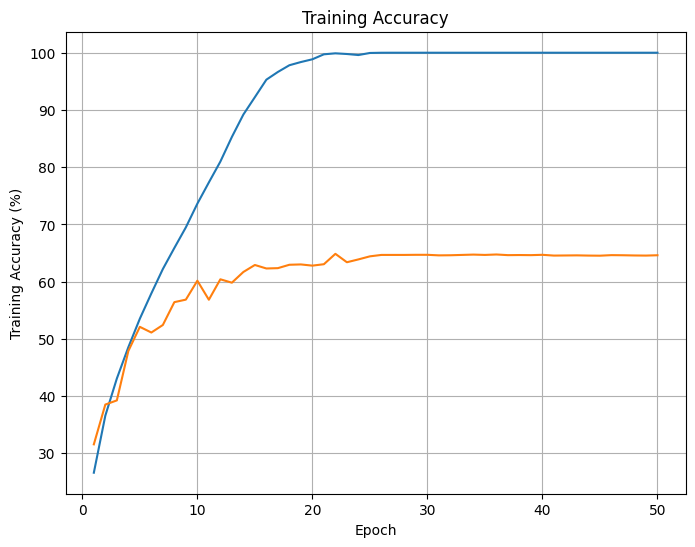

In [20]:
import matplotlib.pyplot as plt
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.plot(range(1, len(test_losses)+1), test_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss')
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()
# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies)
plt.plot(range(1, len(test_accuracies)+1), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 리사이징
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

In [3]:
# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

In [4]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=0.0005)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [7]:
# 모델 훈련
import time
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    elapsed_time = time.time() - start_time
    test(model, test_loader)
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")

Train Loss: 1.7114, Accuracy: 39.71%
Test Loss: 1.6589, Accuracy: 41.94%
Epoch 1 completed in 123.28 seconds
Train Loss: 1.3296, Accuracy: 54.36%
Test Loss: 1.4430, Accuracy: 53.28%
Epoch 2 completed in 218.90 seconds
Train Loss: 1.1662, Accuracy: 59.96%
Test Loss: 1.6923, Accuracy: 45.86%
Epoch 3 completed in 300.08 seconds
Train Loss: 1.0519, Accuracy: 63.97%
Test Loss: 1.2320, Accuracy: 58.37%
Epoch 4 completed in 380.84 seconds
Train Loss: 0.9599, Accuracy: 66.81%
Test Loss: 1.0813, Accuracy: 63.03%
Epoch 5 completed in 461.05 seconds
Train Loss: 0.8793, Accuracy: 69.51%
Test Loss: 1.4190, Accuracy: 55.44%
Epoch 6 completed in 542.46 seconds
Train Loss: 0.7873, Accuracy: 72.73%
Test Loss: 1.1254, Accuracy: 63.54%
Epoch 7 completed in 633.04 seconds
Train Loss: 0.7317, Accuracy: 74.66%
Test Loss: 1.0424, Accuracy: 64.42%
Epoch 8 completed in 776.65 seconds
Train Loss: 0.6700, Accuracy: 77.50%
Test Loss: 1.1922, Accuracy: 61.82%
Epoch 9 completed in 857.26 seconds
Train Loss: 0.6103,

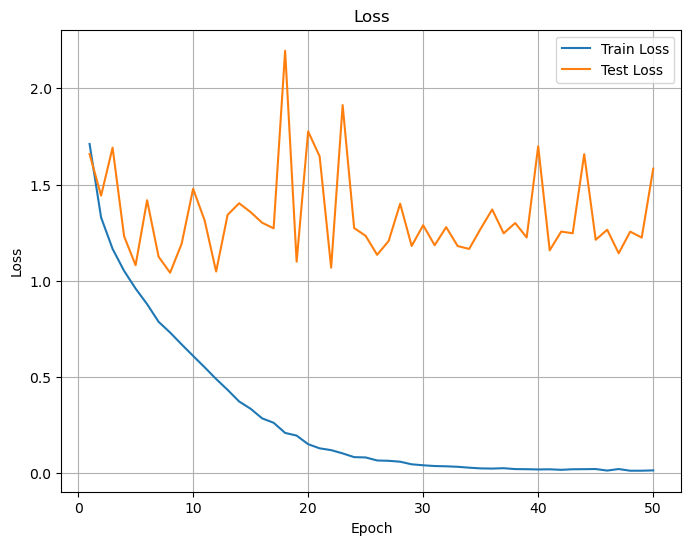

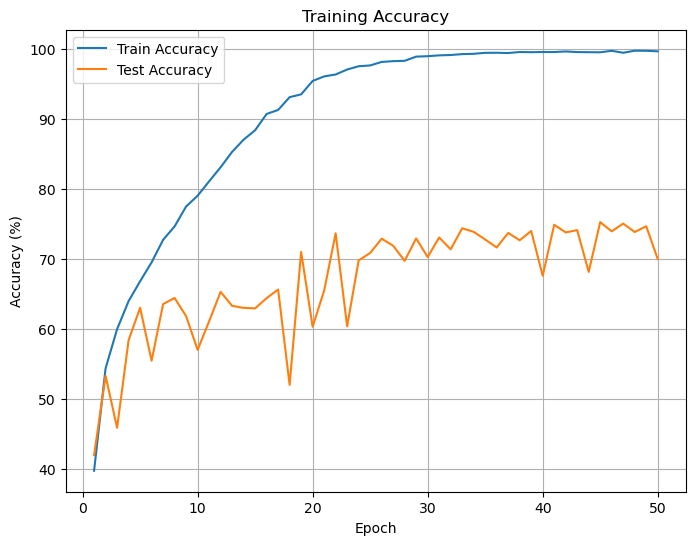

In [8]:
import matplotlib.pyplot as plt
# 에포크에 따른 손실함수 라인그래프 그리기
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)


In [3]:

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



In [10]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 줄인 필터 개수
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 줄인 필터 개수
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*16*16, 128)  # 줄인 FC 레이어 차원
        self.dropout = nn.Dropout(0.3)  # 드롭아웃 비율 증가
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = x.view(-1, 32*16*16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=0.0001)  # weight_decay 값 조정




In [11]:

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [12]:
# 모델 훈련
import time
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    elapsed_time = time.time() - start_time
    test(model, test_loader)
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")

Train Loss: 1.7761, Accuracy: 37.93%
Test Loss: 1.6048, Accuracy: 44.67%
Epoch 1 completed in 42.80 seconds
Train Loss: 1.4602, Accuracy: 49.66%
Test Loss: 1.4224, Accuracy: 50.59%
Epoch 2 completed in 95.38 seconds
Train Loss: 1.3031, Accuracy: 54.95%
Test Loss: 1.4686, Accuracy: 49.52%
Epoch 3 completed in 147.01 seconds
Train Loss: 1.1879, Accuracy: 59.31%
Test Loss: 1.1733, Accuracy: 59.70%
Epoch 4 completed in 199.61 seconds
Train Loss: 1.0965, Accuracy: 62.64%
Test Loss: 1.3775, Accuracy: 52.90%
Epoch 5 completed in 251.46 seconds
Train Loss: 1.0182, Accuracy: 65.32%
Test Loss: 1.1190, Accuracy: 61.63%
Epoch 6 completed in 302.84 seconds
Train Loss: 0.9270, Accuracy: 68.11%
Test Loss: 1.2430, Accuracy: 58.98%
Epoch 7 completed in 355.87 seconds
Train Loss: 0.8562, Accuracy: 70.57%
Test Loss: 1.2268, Accuracy: 60.14%
Epoch 8 completed in 408.81 seconds
Train Loss: 0.7798, Accuracy: 73.19%
Test Loss: 1.1668, Accuracy: 60.71%
Epoch 9 completed in 460.91 seconds
Train Loss: 0.7048, A

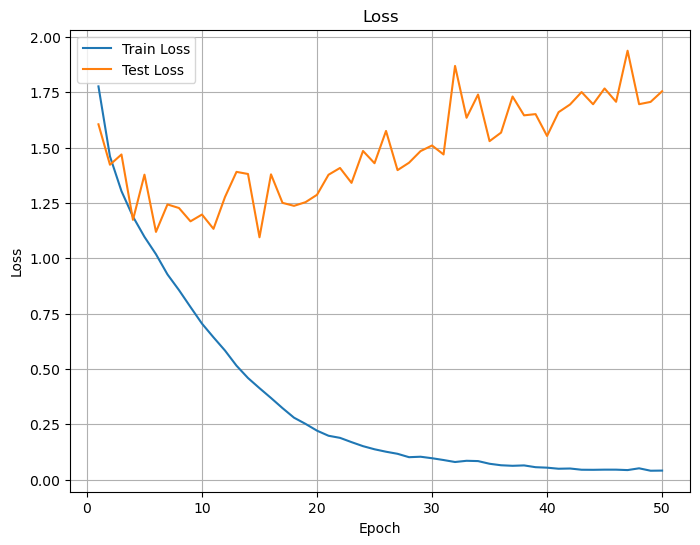

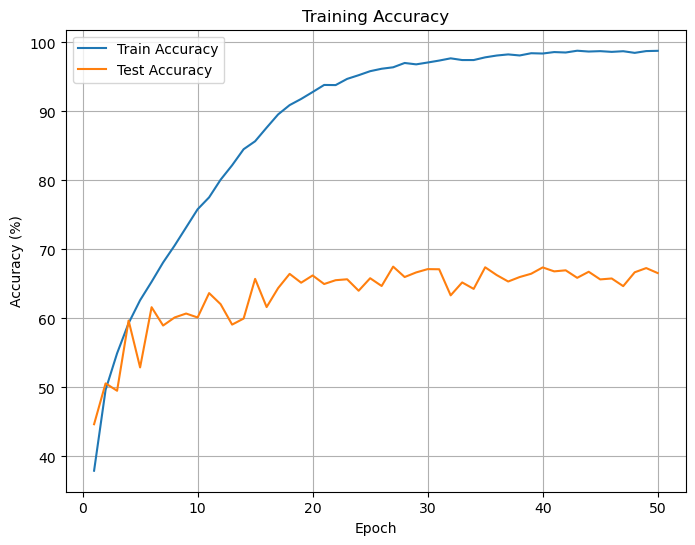

In [13]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()

In [1]:
import os
import shutil
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 리사이징
    transforms.RandomHorizontalFlip(),  # 데이터 증강: 좌우 반전
    transforms.RandomRotation(10),  # 데이터 증강: 회전
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [3]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [4]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [5]:
# 모델 훈련
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    test(model, test_loader)
    scheduler.step()
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")

Train Loss: 2.0669, Accuracy: 26.92%
Test Loss: 1.8177, Accuracy: 38.18%
Epoch 1 completed in 144.27 seconds
Train Loss: 1.7613, Accuracy: 37.01%
Test Loss: 1.5014, Accuracy: 48.40%
Epoch 2 completed in 219.15 seconds
Train Loss: 1.5945, Accuracy: 43.46%
Test Loss: 1.3519, Accuracy: 53.32%
Epoch 3 completed in 293.85 seconds
Train Loss: 1.4836, Accuracy: 47.83%
Test Loss: 1.2692, Accuracy: 57.31%
Epoch 4 completed in 368.17 seconds
Train Loss: 1.4178, Accuracy: 50.41%
Test Loss: 1.1934, Accuracy: 57.54%
Epoch 5 completed in 444.67 seconds
Train Loss: 1.3744, Accuracy: 51.98%
Test Loss: 1.2332, Accuracy: 57.22%
Epoch 6 completed in 527.51 seconds
Train Loss: 1.3268, Accuracy: 53.70%
Test Loss: 1.1882, Accuracy: 60.85%
Epoch 7 completed in 613.51 seconds
Train Loss: 1.2781, Accuracy: 55.47%
Test Loss: 1.0760, Accuracy: 63.87%
Epoch 8 completed in 703.77 seconds
Train Loss: 1.2432, Accuracy: 56.33%
Test Loss: 1.1141, Accuracy: 63.54%
Epoch 9 completed in 795.27 seconds
Train Loss: 1.2216,

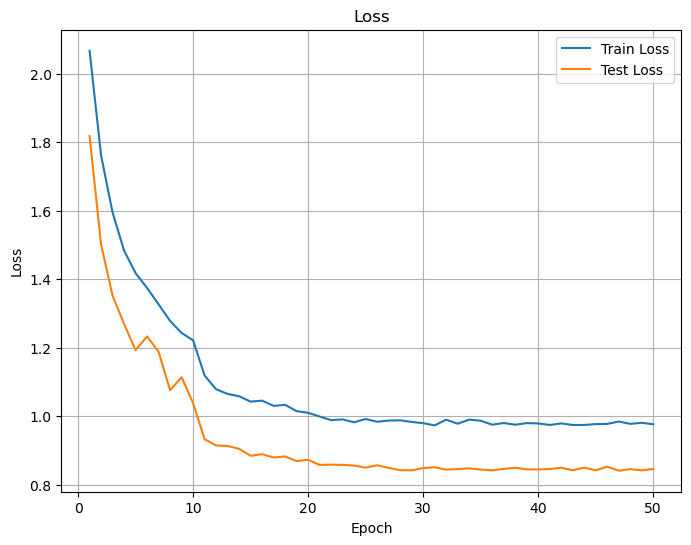

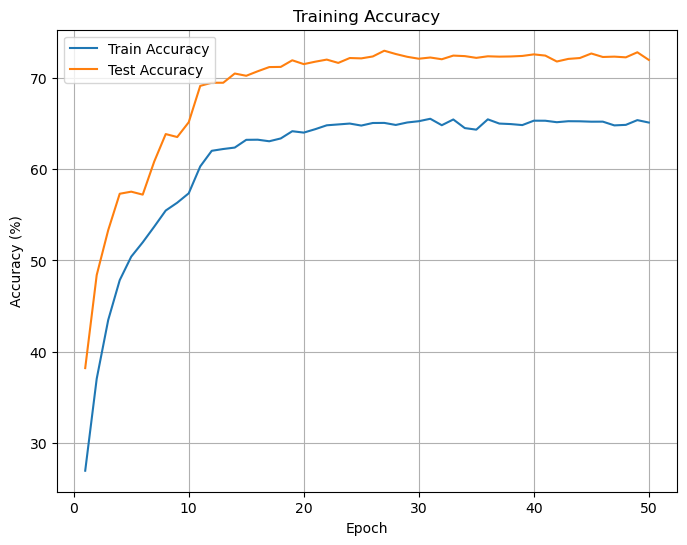

In [6]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()


In [18]:
import os
import shutil
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split



In [19]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 리사이징
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [20]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [21]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')



In [22]:
# 모델 훈련
start_time = time.time()
for epoch in range(70):
    train(model, train_loader, optimizer)
    test(model, test_loader)
    scheduler.step()
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")

Train Loss: 2.8300, Accuracy: 18.88%
Test Loss: 2.1909, Accuracy: 19.90%
Epoch 1 completed in 136.98 seconds
Train Loss: 2.1903, Accuracy: 19.96%
Test Loss: 2.1737, Accuracy: 21.10%
Epoch 2 completed in 206.42 seconds
Train Loss: 2.1799, Accuracy: 20.56%
Test Loss: 2.1345, Accuracy: 23.03%
Epoch 3 completed in 275.50 seconds
Train Loss: 2.1589, Accuracy: 21.94%
Test Loss: 2.1401, Accuracy: 22.71%
Epoch 4 completed in 345.44 seconds
Train Loss: 2.1505, Accuracy: 22.50%
Test Loss: 2.1340, Accuracy: 24.10%
Epoch 5 completed in 419.38 seconds
Train Loss: 2.1485, Accuracy: 22.84%
Test Loss: 2.1370, Accuracy: 23.99%
Epoch 6 completed in 519.76 seconds
Train Loss: 2.1169, Accuracy: 24.18%
Test Loss: 1.9969, Accuracy: 27.50%
Epoch 7 completed in 628.58 seconds
Train Loss: 1.9951, Accuracy: 28.74%
Test Loss: 1.8362, Accuracy: 35.66%
Epoch 8 completed in 743.70 seconds
Train Loss: 1.8975, Accuracy: 32.95%
Test Loss: 1.7040, Accuracy: 39.82%
Epoch 9 completed in 863.31 seconds
Train Loss: 1.7841,

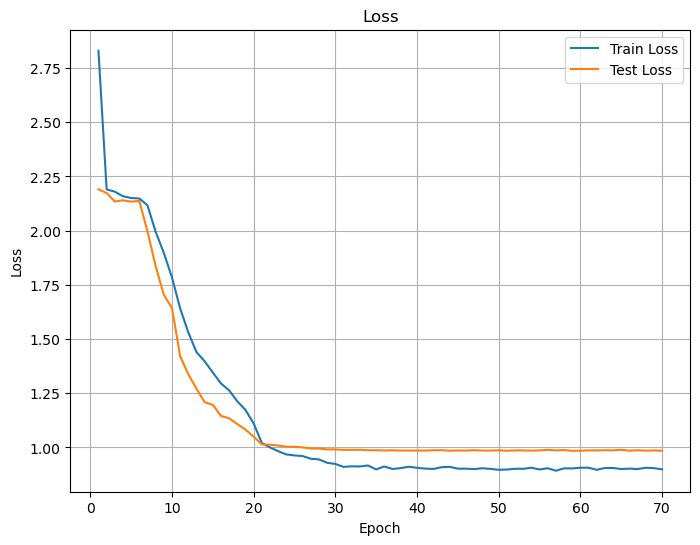

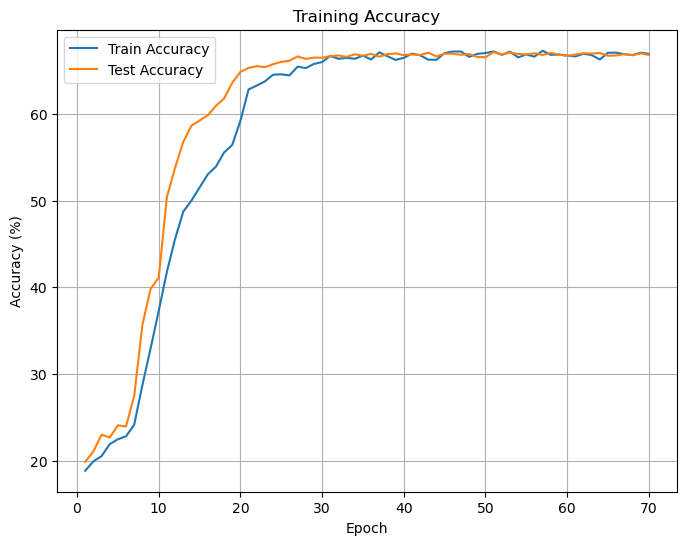

In [24]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()

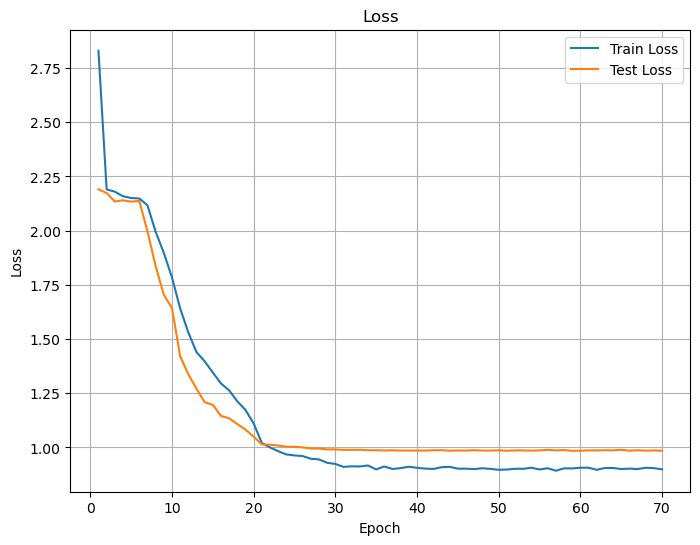

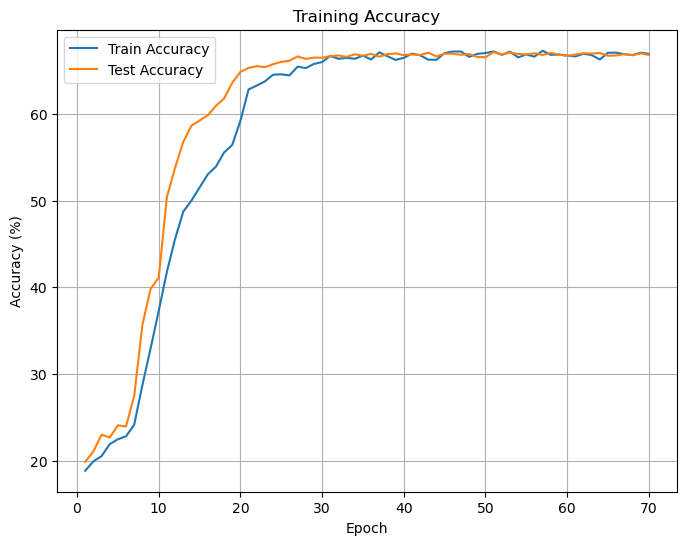

In [23]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()


In [9]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 리사이징
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)




In [14]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')




In [16]:
# 모델 훈련
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    test(model, test_loader)
    scheduler.step()
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")




Train Loss: 3.6380, Accuracy: 17.65%
Test Loss: 2.2077, Accuracy: 18.58%
Epoch 1 completed in 137.65 seconds
Train Loss: 2.2119, Accuracy: 18.36%
Test Loss: 2.2965, Accuracy: 18.58%
Epoch 2 completed in 207.91 seconds
Train Loss: 2.2165, Accuracy: 18.87%
Test Loss: 2.2216, Accuracy: 18.30%
Epoch 3 completed in 278.98 seconds
Train Loss: 2.1622, Accuracy: 21.67%
Test Loss: 2.1146, Accuracy: 24.41%
Epoch 4 completed in 351.36 seconds
Train Loss: 2.1635, Accuracy: 21.99%
Test Loss: 2.1163, Accuracy: 23.36%
Epoch 5 completed in 433.66 seconds
Train Loss: 2.1396, Accuracy: 23.22%
Test Loss: 2.1078, Accuracy: 25.31%
Epoch 6 completed in 570.01 seconds
Train Loss: 2.1055, Accuracy: 24.37%
Test Loss: 2.0682, Accuracy: 23.62%
Epoch 7 completed in 734.06 seconds
Train Loss: 2.0975, Accuracy: 24.71%
Test Loss: 2.0342, Accuracy: 26.18%
Epoch 8 completed in 907.67 seconds
Train Loss: 2.0693, Accuracy: 26.19%
Test Loss: 1.9899, Accuracy: 30.48%
Epoch 9 completed in 1093.31 seconds
Train Loss: 2.0527

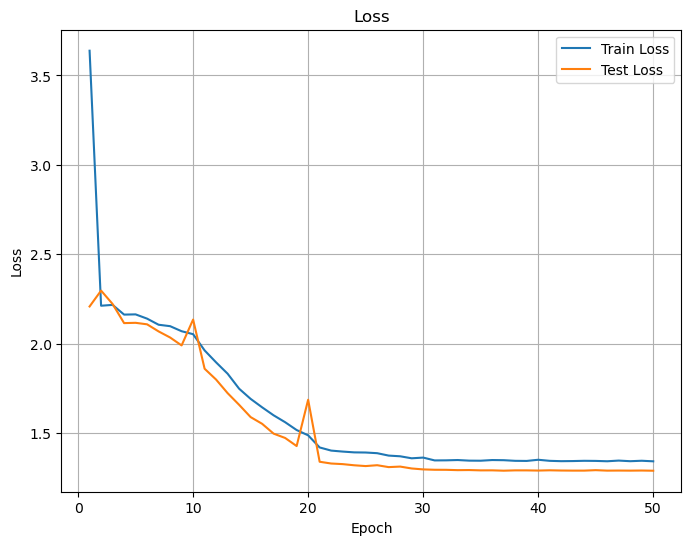

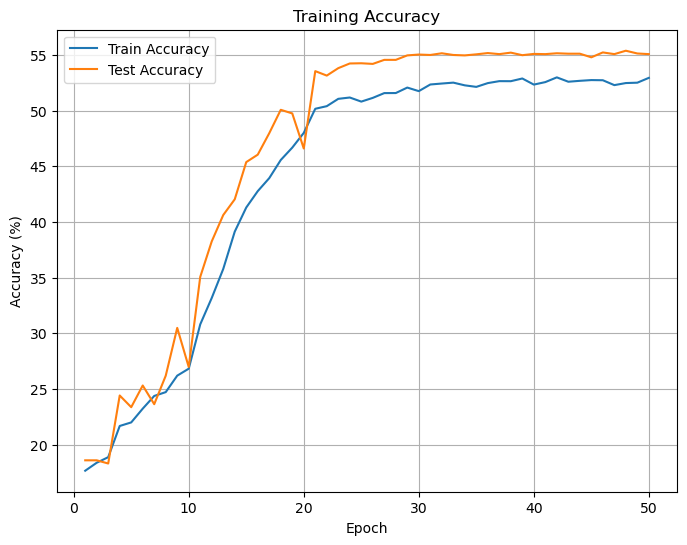

In [17]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

In [3]:
# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [4]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 줄인 필터 개수
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 줄인 필터 개수
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*16*16, 128)  # 줄인 FC 레이어 차원
        self.dropout = nn.Dropout(0.4)  # 드롭아웃 비율 증가
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = x.view(-1, 32*16*16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.5, weight_decay=0.00015)  # weight_decay 값 조정



In [5]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')



In [7]:
# 모델 훈련
import time
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    elapsed_time = time.time() - start_time
    test(model, test_loader)
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")



Train Loss: 1.8491, Accuracy: 34.58%
Test Loss: 1.5919, Accuracy: 44.48%
Epoch 1 completed in 97.59 seconds
Train Loss: 1.5397, Accuracy: 46.99%
Test Loss: 1.5535, Accuracy: 45.74%
Epoch 2 completed in 164.28 seconds
Train Loss: 1.3930, Accuracy: 51.83%
Test Loss: 1.3924, Accuracy: 52.81%
Epoch 3 completed in 217.70 seconds
Train Loss: 1.2836, Accuracy: 55.94%
Test Loss: 1.3356, Accuracy: 53.11%
Epoch 4 completed in 270.05 seconds
Train Loss: 1.1908, Accuracy: 59.67%
Test Loss: 1.2997, Accuracy: 54.83%
Epoch 5 completed in 324.22 seconds
Train Loss: 1.1143, Accuracy: 62.03%
Test Loss: 1.2575, Accuracy: 56.82%
Epoch 6 completed in 377.66 seconds
Train Loss: 1.0462, Accuracy: 64.18%
Test Loss: 1.2412, Accuracy: 57.60%
Epoch 7 completed in 430.84 seconds
Train Loss: 0.9791, Accuracy: 66.65%
Test Loss: 1.0923, Accuracy: 63.77%
Epoch 8 completed in 484.14 seconds
Train Loss: 0.9043, Accuracy: 68.89%
Test Loss: 1.1172, Accuracy: 62.85%
Epoch 9 completed in 536.70 seconds
Train Loss: 0.8564, 

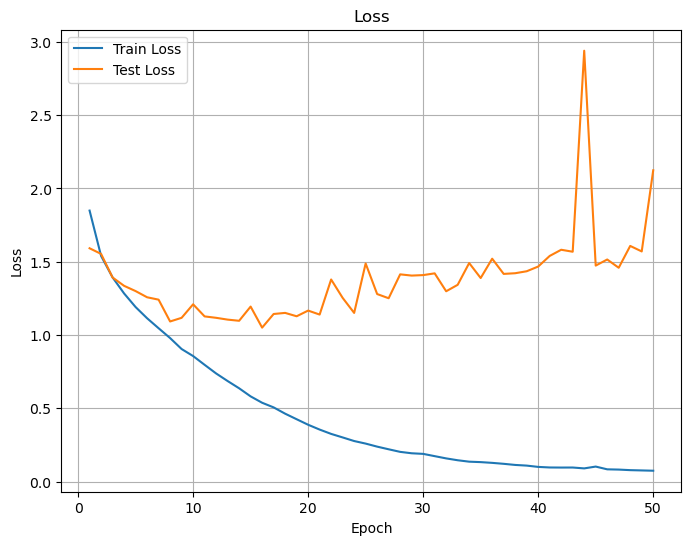

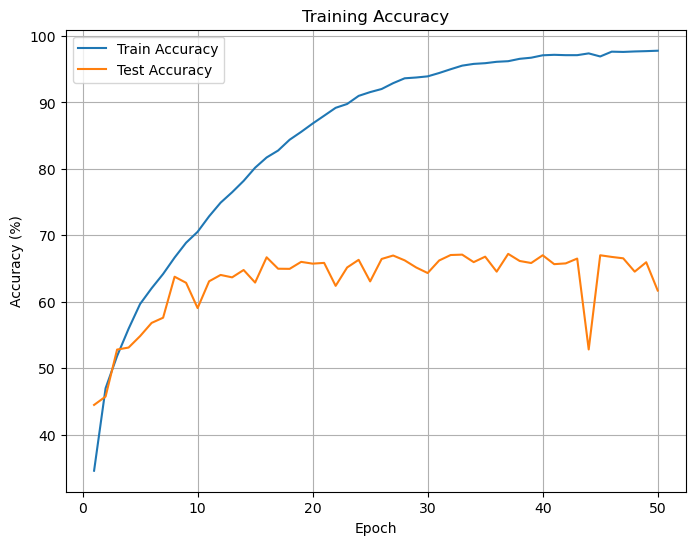

In [8]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [10]:
# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\user\Downloads\animals10\raw-img'

# 원본 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 번역
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 클래스 이름 변경
dataset.classes = [translate.get(item, item) for item in dataset.classes]

# 데이터와 타겟을 포함한 samples 리스트
data = [x[0] for x in dataset.samples]
target = [x[1] for x in dataset.samples]

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# 트레인/테스트 데이터셋 저장 경로 설정
train_dir = r'C:\Users\user\Downloads\animals10\train'
test_dir = r'C:\Users\user\Downloads\animals10\test'

# 디렉토리 생성 함수
def create_class_directories(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# 이미지 저장 함수
def save_images(inputs, targets, base_dir):
    for img_path, target in zip(inputs, targets):
        class_name = dataset.classes[target]
        save_path = os.path.join(base_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, save_path)

In [11]:
# 클래스 디렉토리 생성
create_class_directories(train_dir, dataset.classes)
create_class_directories(test_dir, dataset.classes)

# 이미지 저장
save_images(train_input, train_target, train_dir)
save_images(test_input, test_target, test_dir)

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2135, 0.2130, 0.2151))
])

# 새로 저장된 데이터셋 로드
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [14]:
# CNN 모델 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))  
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.012, weight_decay=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [16]:
# 모델 훈련
start_time = time.time()
for epoch in range(50):
    train(model, train_loader, optimizer)
    test(model, test_loader)
    scheduler.step()
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds")

Train Loss: 3.0493, Accuracy: 19.43%
Test Loss: 2.1744, Accuracy: 23.85%
Epoch 1 completed in 135.09 seconds
Train Loss: 2.1985, Accuracy: 20.76%
Test Loss: 2.2058, Accuracy: 20.21%
Epoch 2 completed in 203.95 seconds
Train Loss: 2.2134, Accuracy: 18.29%
Test Loss: 2.2086, Accuracy: 18.41%
Epoch 3 completed in 274.36 seconds
Train Loss: 2.2297, Accuracy: 18.31%
Test Loss: 2.2080, Accuracy: 18.56%
Epoch 4 completed in 349.31 seconds
Train Loss: 2.1898, Accuracy: 20.87%
Test Loss: 2.1390, Accuracy: 22.54%
Epoch 5 completed in 429.40 seconds
Train Loss: 2.1230, Accuracy: 24.28%
Test Loss: 2.2538, Accuracy: 20.76%
Epoch 6 completed in 542.60 seconds
Train Loss: 2.0512, Accuracy: 27.11%
Test Loss: 2.4797, Accuracy: 21.58%
Epoch 7 completed in 672.12 seconds
Train Loss: 1.9597, Accuracy: 30.98%
Test Loss: 2.9137, Accuracy: 28.82%
Epoch 8 completed in 811.97 seconds
Train Loss: 1.8894, Accuracy: 33.67%
Test Loss: 1.7573, Accuracy: 37.61%
Epoch 9 completed in 961.98 seconds
Train Loss: 1.8221,

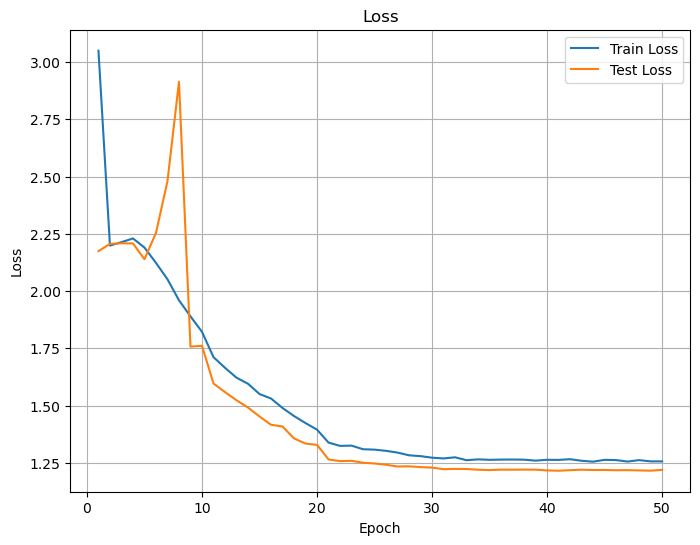

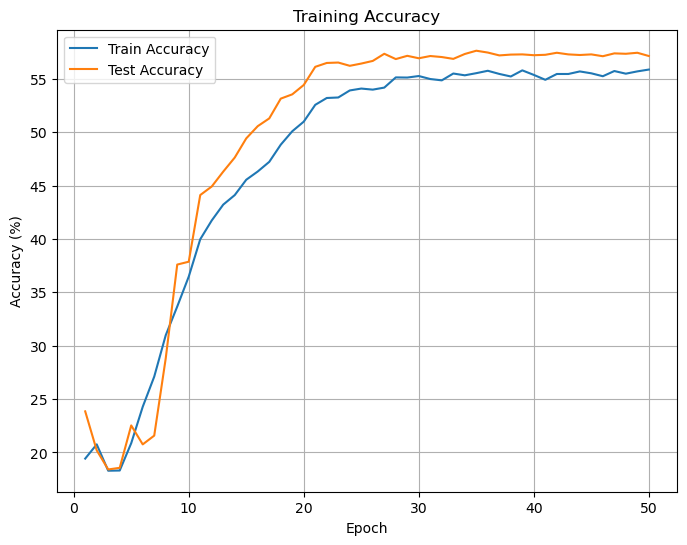

In [17]:
# 에포크에 따른 손실함수 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# 에포크에 따른 정확도 라인그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')
plt.show()